In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import tensorflow as tf
import cv2
from skimage import io
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [2]:
# Load Data

def load_data(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])
    
    # Match labels with corresponding images
    matched_images = []
    matched_labels = []
    
    for img_file in image_files:
        label_file = img_file.replace('.tif', '.png')
        if label_file in label_files:
            matched_images.append(os.path.join(image_dir, img_file))
            matched_labels.append(os.path.join(label_dir, label_file))
        else:
            print(f"Warning: No matching label for {img_file}")
    
    images = np.array([tiff.imread(f) for f in matched_images])
    labels = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in matched_labels])
    
    images = images / 255.0  # Normalize images
    labels = (labels > 0.5).astype(np.uint8)  # Convert labels to binary mask
    
    if labels.ndim == 3:
        labels = np.expand_dims(labels, axis=-1)  # Ensure labels have a channel dimension
    
    return images, labels

In [3]:
def display_image_and_mask(img_path, mask_path):
    img = io.imread(img_path)  # Load TIFF image
    
    # Convert multi-channel image to RGB (Keep first 3 channels)
    if len(img.shape) == 3 and img.shape[-1] > 3:
        img = img[:, :, :3]  # Select the first 3 channels

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Load mask

    # Convert mask to grayscale if needed
    if mask is not None and len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Display the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()

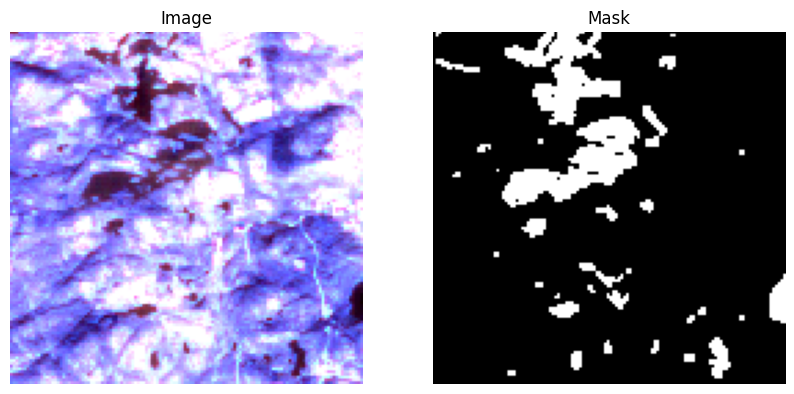

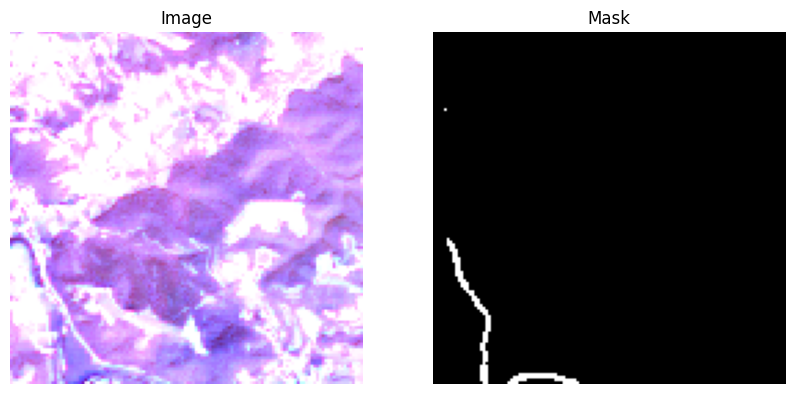

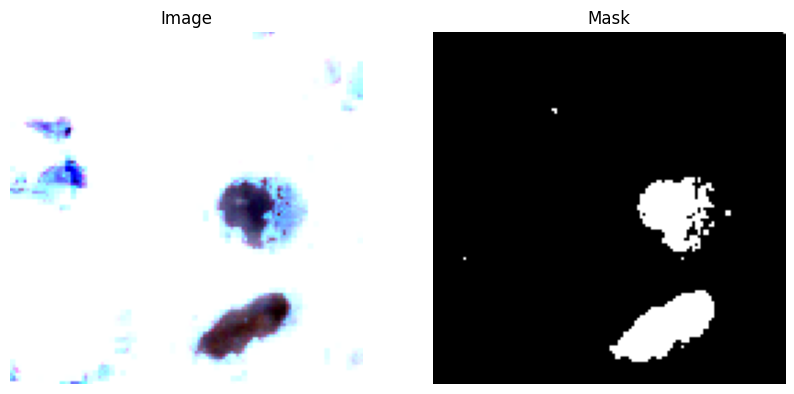

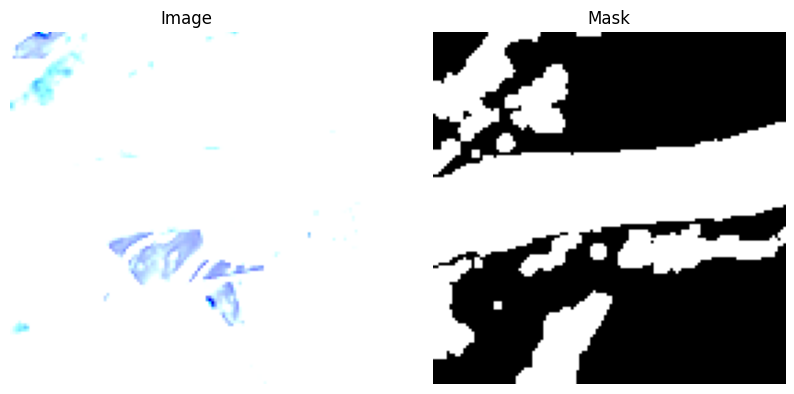

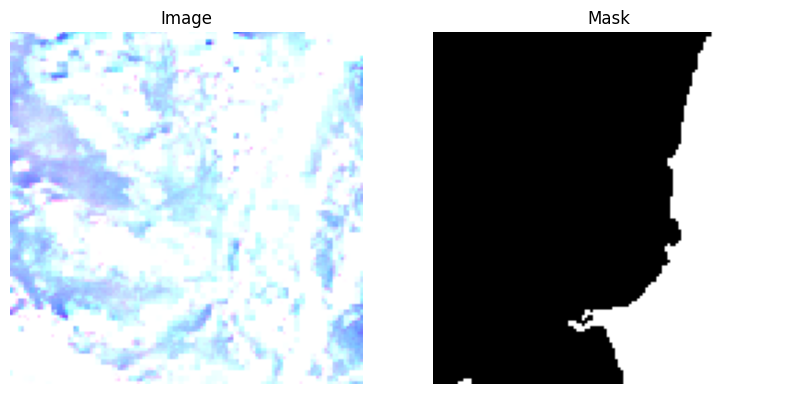

In [4]:
train_img_dir = "/kaggle/input/water-segmentation/data/images"
train_mask_dir = "/kaggle/input/water-segmentation/data/labels"

train_img_files = sorted(os.listdir(train_img_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)
    display_image_and_mask(img_path, mask_path)

In [5]:
# Data Generator Class
class ImageLabelGenerator(Sequence):
    def __init__(self, images, labels, batch_size, augmentations):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.indexes = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        if self.augmentations:
            batch_images, batch_labels = next(self.augmentations.flow(batch_images, batch_labels, batch_size=self.batch_size))
        
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)



In [6]:
# Data Augmentation
image_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
label_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')

image_dir = "/kaggle/input/water-segmentation/data/images"
label_dir = "/kaggle/input/water-segmentation/data/labels"
images, labels = load_data(image_dir, label_dir)

In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
# Define U-Net Model
def unet_model(input_shape=(128, 128, 12)):
    inputs = Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Create data generators
train_generator = ImageLabelGenerator(X_train, y_train, batch_size=16, augmentations=image_datagen)
val_generator = ImageLabelGenerator(X_test, y_test, batch_size=16, augmentations=None)

# Train Model
model = unet_model()
model.fit(train_generator, epochs=20, validation_data=val_generator)


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 128, 128, 12) (12 channels).
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - accuracy: 0.7355 - loss: 0.5538 - val_accuracy: 0.9007 - val_loss: 0.3324
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8100 - loss: 0.4421 - val_accuracy: 0.8882 - val_loss: 0.3173
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8113 - loss: 0.4414 - val_accuracy: 0.9043 - val_loss: 0.3402
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.8307 - loss: 0.4236 - val_accuracy: 0.8920 - val_loss: 0.3540
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.8169 - loss: 0.4263 - val_accuracy: 0.9012 - val_loss: 0.2917
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.8323 - loss: 0.4040 - val_accuracy: 0.9031 - val_loss: 0.3161
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.8175 - loss: 0.4113 - val_accuracy: 0.9199 - val_loss: 0.2409
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.8168 - loss: 0.4248 - val_accuracy: 0.9104 - val

In [10]:
# Evaluate Model
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(np.uint8)

iou = jaccard_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
precision = precision_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
recall = recall_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)
f1 = f1_score(y_test.flatten(), predictions.flatten(), average='binary', zero_division=1)

print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step
IoU: 0.5904
Precision: 0.8132
Recall: 0.6831
F1 Score: 0.7425


In [11]:
loss, accuracy = model.evaluate(val_generator, steps=50)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9009 - loss: 0.3051 
Validation Loss: 0.30377069115638733
Validation Accuracy: 0.9012768864631653


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


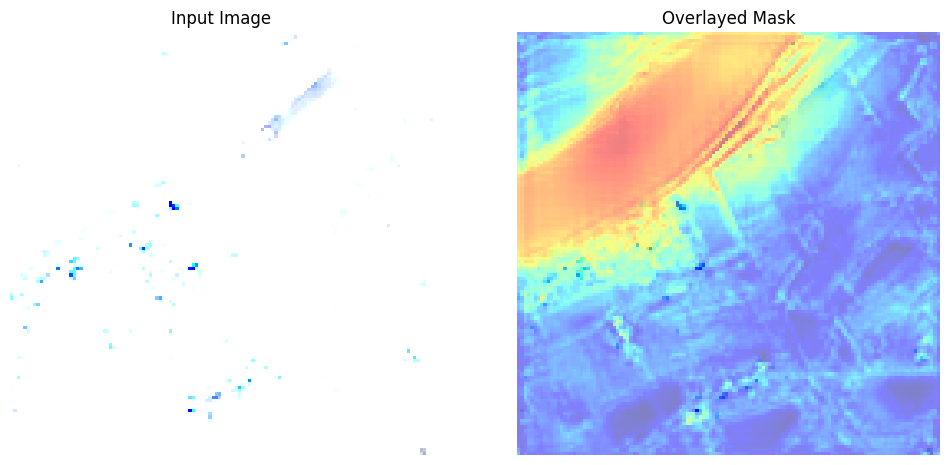

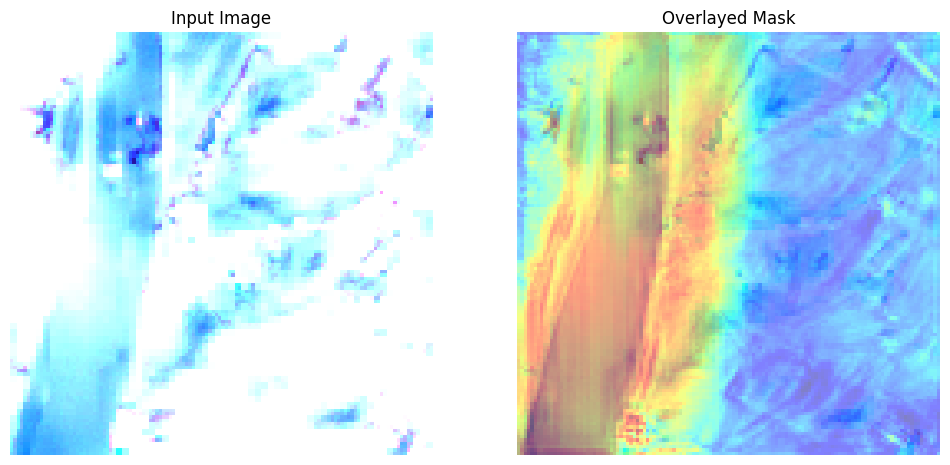

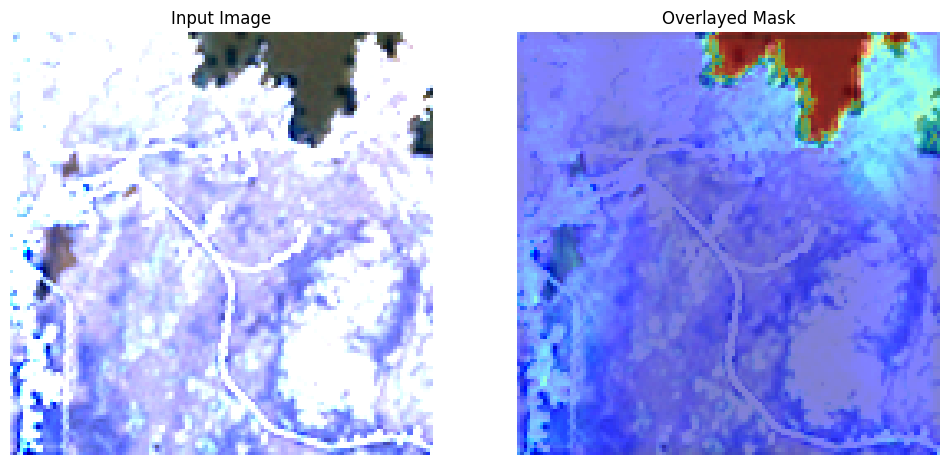

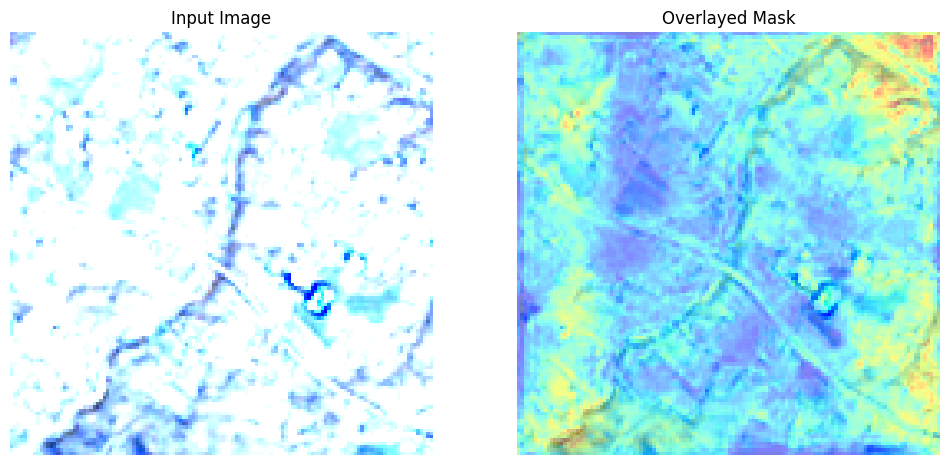

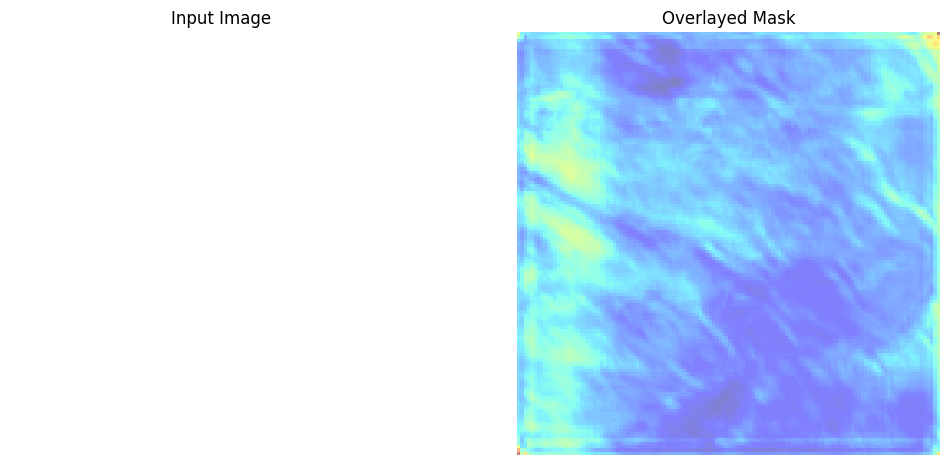

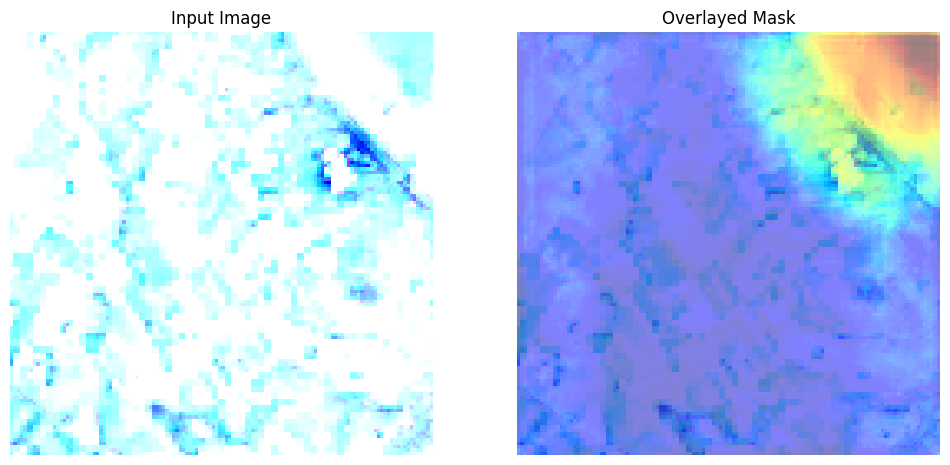

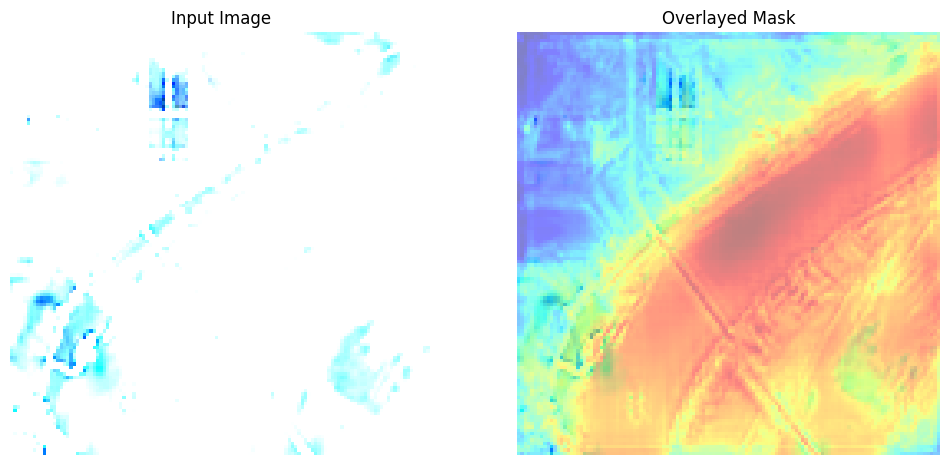

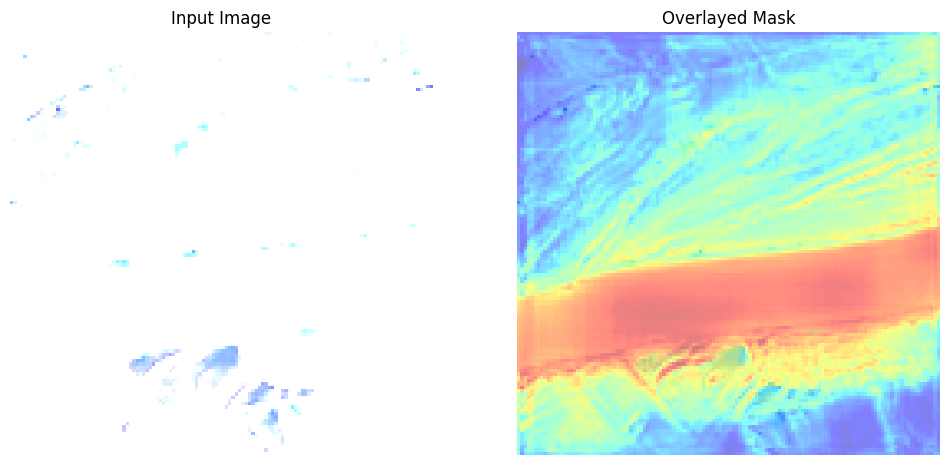

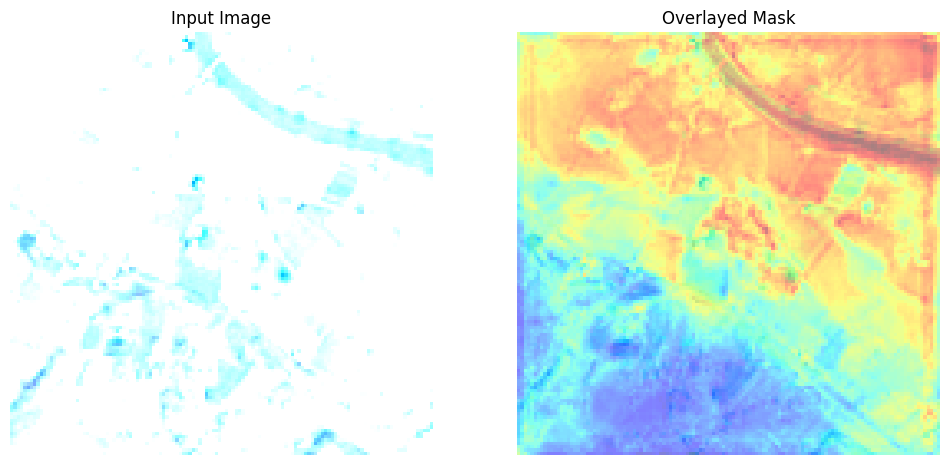

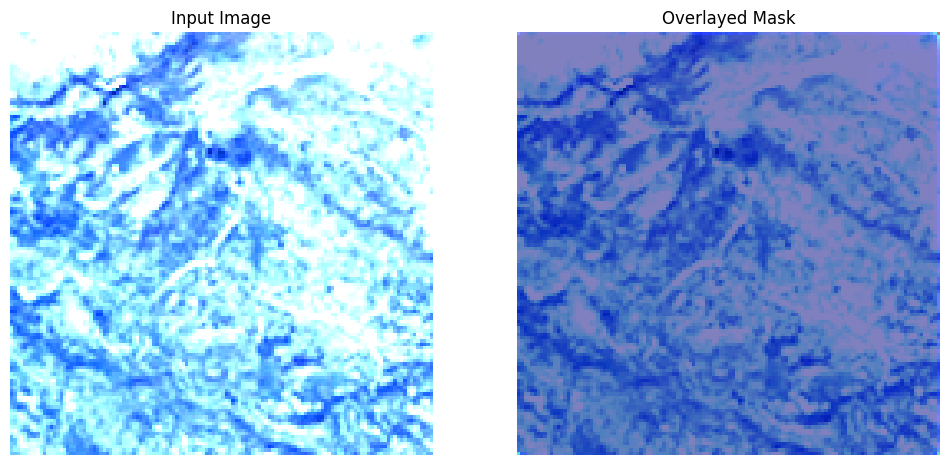

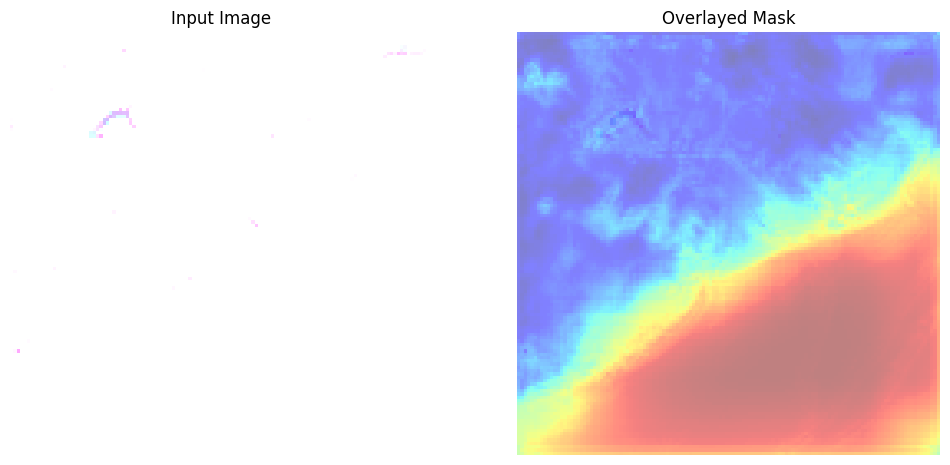

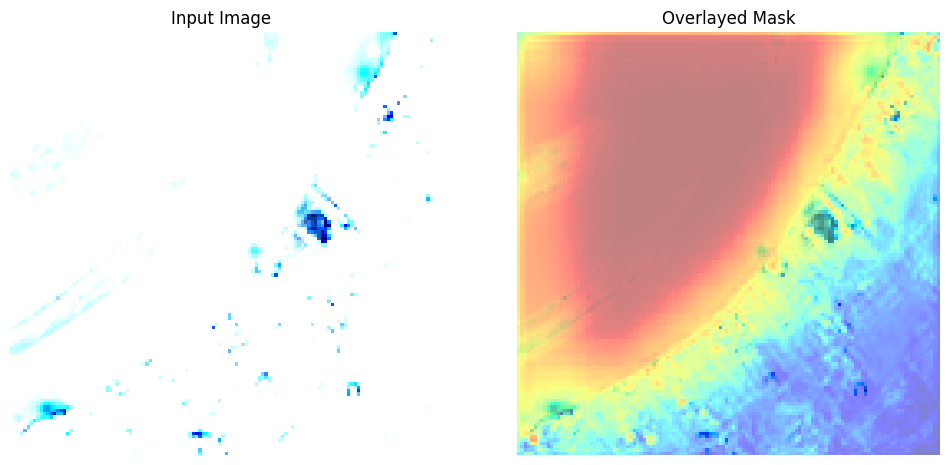

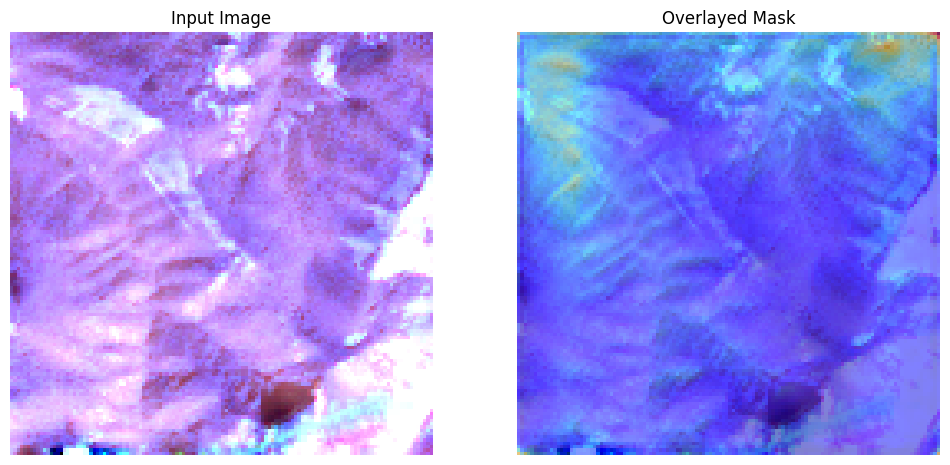

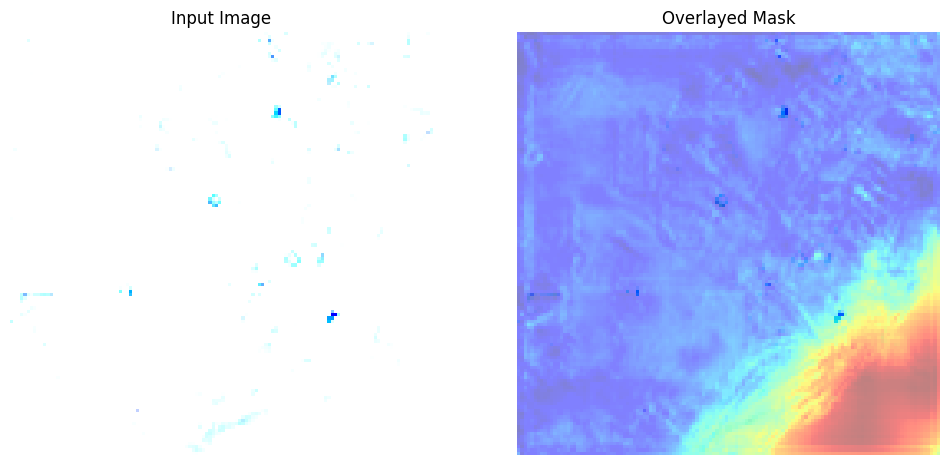

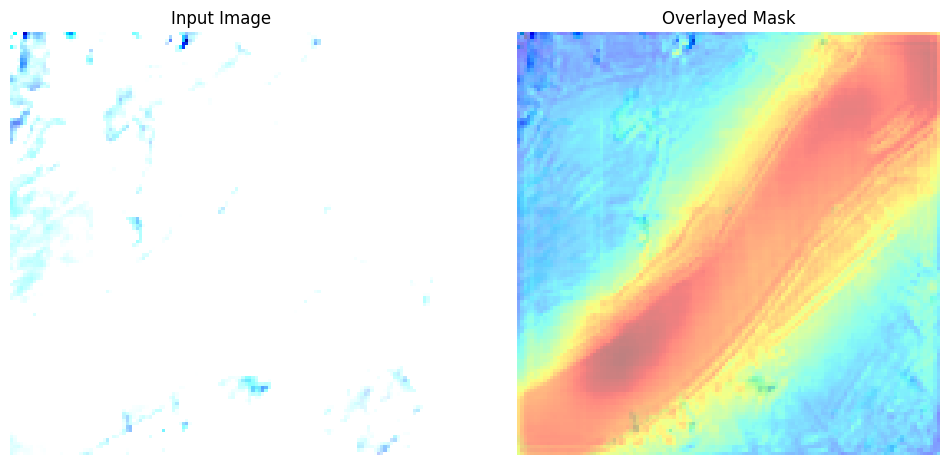

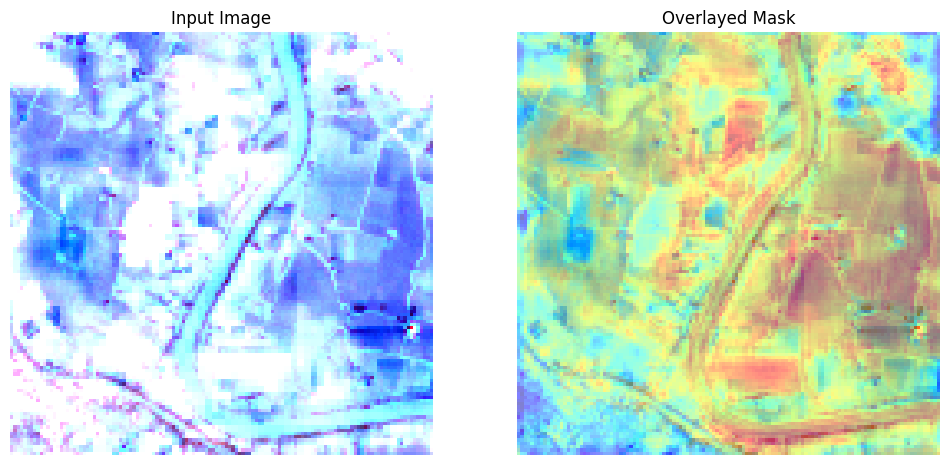

In [12]:
# Overlay Predictions
def overlay_predictions(model, generator, alpha=0.5):
    generator_iter = iter(generator)
    images, masks = next(generator_iter)
    predictions = model.predict(images)

    for i in range(len(images)):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        if images.shape[-1] > 3:
            plt.imshow(images[i, :, :, :3])  # Use first 3 channels as RGB
        else:
            plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Overlayed Mask")
        if images.shape[-1] > 3:
            plt.imshow(images[i, :, :, :3])
        else:
            plt.imshow(images[i])
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.show()

# Display overlayed predictions
overlay_predictions(model, val_generator)